##                       FashinMart - Timeseries analysis( Analyse Customer purchase trend and seasonality )

In [ ]:
########################################################################################################################
#
# Script name               - FashinMart_Timeseries_analysis.ipynb
# Script description        - This notebook will do download data from cloud and do timeseries analysis on purchase behavior
# Usage                     - 
# Input Params needed       - 
#
#
#  Date                        Author                        Modification                       Description
# =====                       =======                        =============                     =============
# 17-Sep-2019                 Praveen                        Created
#
#
########################################################################################################################

## Business description


### Building timeseries model for forecasing & interpreting trend and seasonality in the data
To know Customer purchase trend and seasonality in FashinMart , we are going to build econometric model. It will help to know trend and seasonality

Activity in below analysis

##### Check Stationarity of a Time Series - 
##### Trend 
##### Seasonality
##### Making forecast
##### Comparing trend of Furniture and Tech product sales

###  Key Assumptions : 
                    Seasonality & Anamoly on the data is retained for analysis. 
                    Ideal timeseries analysis does not hold seasonality and anamoly like big sale day 

Imprting necessary libraries 

In [3]:
import reusables as re
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from logger import myLogger
warnings.simplefilter('ignore')

## Assigning Matlab params

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [4]:
script_name='CC_2_FashinMart_Timeseries_analysis'
reusable = re.reusables(script_name=script_name)

## Data preperation

In [5]:
df_mba_data = pd.read_csv(reusable.path_sources+'exercise2_input.csv',converters={'Quantity':int,'Sales':float})

In [5]:
df_mba_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 8 columns):
RowID          9994 non-null int64
OrderID        9994 non-null object
OrderDate      9994 non-null object
CustomerID     9994 non-null object
ProductID      9994 non-null object
ProductName    9994 non-null object
Sales          9994 non-null float64
Quantity       9994 non-null int64
dtypes: float64(1), int64(2), object(5)
memory usage: 624.7+ KB


In [6]:
df_mba_data['OrderDate'] = pd.to_datetime(df_mba_data['OrderDate'])
df_mba_data["year"] = df_mba_data["OrderDate"].dt.year

## Stand. the data for time series analysis

In [8]:
df_ts_sales = df_mba_data.groupby('OrderDate')['Sales'].sum().reset_index()

## Indexing the timeseries data

In [10]:
df_ts_sales = df_ts_sales.set_index('OrderDate')
df_ts_sales.index

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-04', '2014-01-06',
               '2014-01-07', '2014-01-08', '2014-01-09', '2014-01-10',
               '2014-01-11', '2014-01-12',
               ...
               '2017-12-21', '2017-12-22', '2017-12-23', '2017-12-24',
               '2017-12-25', '2017-12-26', '2017-12-27', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='OrderDate', length=1237, freq=None)

## First we will have look at average sales accross months in the dataset 

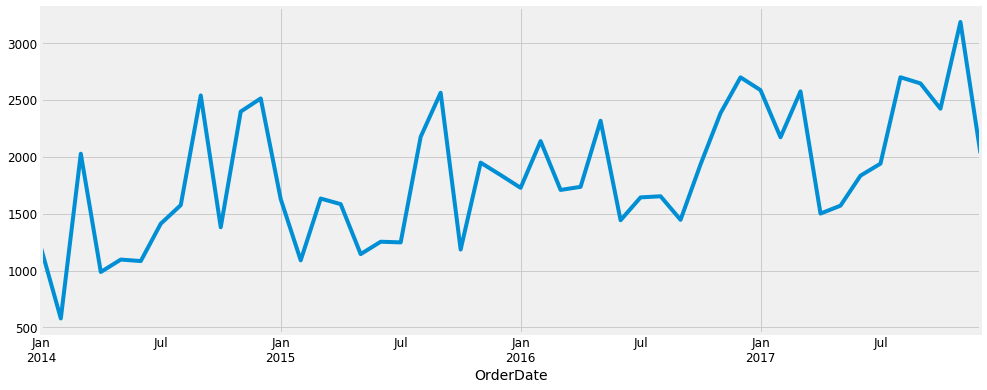

In [14]:
mean = df_ts_sales['Sales'].resample('MS').mean()
mean.plot(figsize=(15, 6))
plt.show()

Let see how the trend and seasonality looks like 

## FashinMart - Average Sales Actuals , trend & seasonality on monthly basis

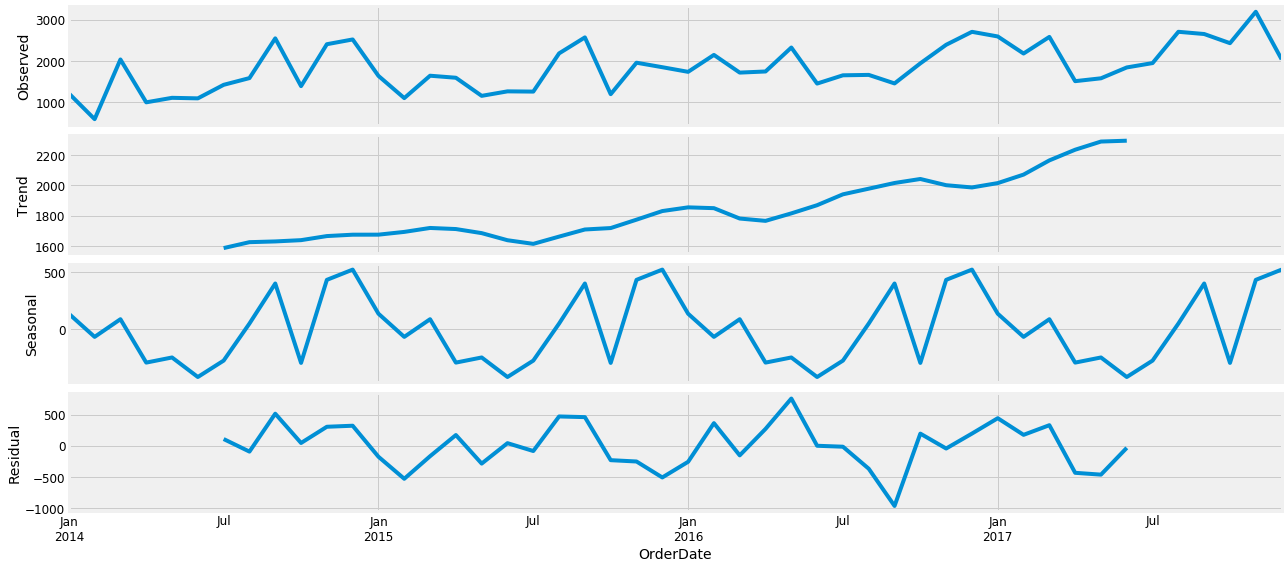

In [19]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(mean, model='additive')
plt.title('',size=30)
fig = decomposition.plot()
plt.show()

## Observation : 
    Based on the above graph , Its is observed that there is upward trend 2014 to 2017 amid bit of slight dip in 2015-June ,2016-Mar & Dec 2017.
    
    Variance in Seasonality is huge

In [20]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


#### This step is parameter Selection for our Sales ARIMA Time Series Model. 
 Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [22]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(mean,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:846.7545980747906
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1558.2296869211011
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:552.3935219283636
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:568.0403610654619
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1511.05732237027
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:384.6994549928634
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:789.0221941508235
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2994.030760069356
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:537.1375070999255
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:568.9522368845794
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:308822965.0746029
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:383.2838966570927
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:724.8868973524789
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1496.761892983851
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:550.7074240313755
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:543.7038519439859
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1751.934494758609
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:373.7677563840197
ARIMA(0, 1

The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value of 348.77. 
Therefore we should consider this to be optimal option.

# Building Timeseries model SARIMAX

In [23]:
mod = sm.tsa.statespace.SARIMAX(mean,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0641      0.233      0.275      0.783      -0.392       0.520
ma.L1         -1.0000      0.374     -2.675      0.007      -1.733      -0.267
ar.S.L12      -0.5284      0.225     -2.353      0.019      -0.968      -0.088
sigma2       2.87e+05    1.3e-06    2.2e+11      0.000    2.87e+05    2.87e+05


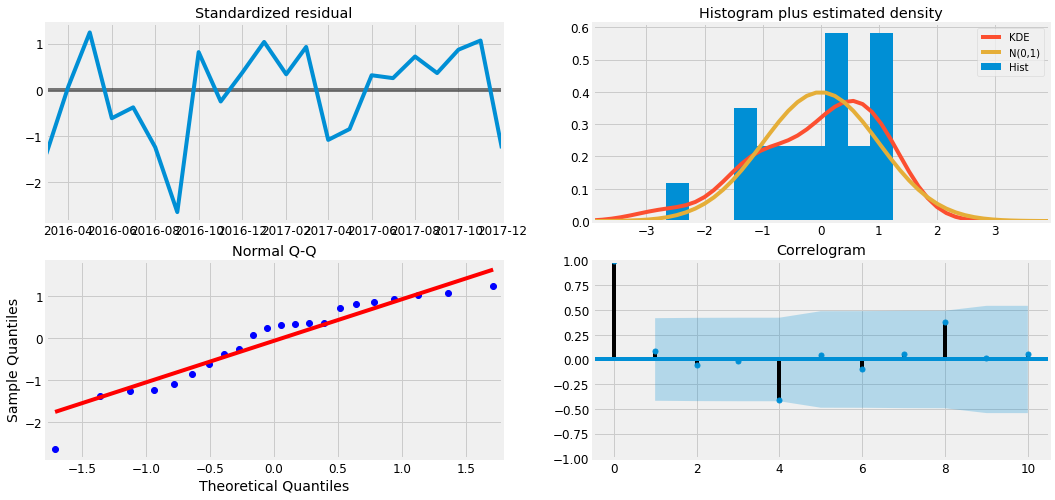

In [27]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Let see how our model forcast for last 8 months 

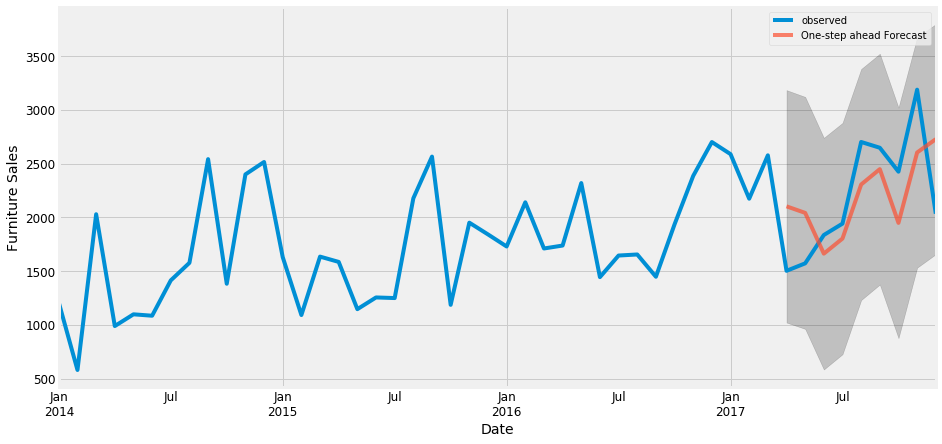

In [30]:
pred = results.get_prediction(start=pd.to_datetime('2017-04-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = mean['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

# Measuring the model performance

In [33]:
y_forecasted = pred.predicted_mean
y_truth = mean['2017-04-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 208795.33


In [34]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 456.94


# Forecasting outlook

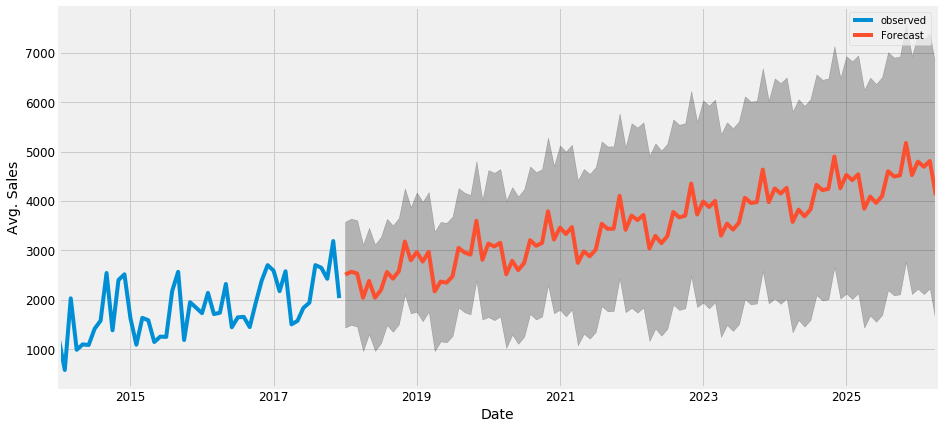

In [35]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = mean.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Avg. Sales')
plt.legend()
plt.show()

# Great !!! Avg. Sales per month in FashinMart is increasing for next 3 years

## Analysing sales forecast of FashinMart products - Furniture & Tech goods

 Let compare how the Technical products and furniture product sales look like 

In [7]:
df_sales_furniture = df_mba_data[df_mba_data['ProductID'].str.contains('FUR-')][['OrderDate','Sales']]
df_sales_Tech_prds = df_mba_data[df_mba_data['ProductID'].str.contains('TEC-')][['OrderDate','Sales']]

In [8]:
df_sales_furniture = df_sales_furniture.sort_values('OrderDate')
df_sales_Tech_prds = df_sales_Tech_prds.sort_values('OrderDate')

df_sales_furniture = df_sales_furniture.groupby('OrderDate')['Sales'].sum().reset_index()
df_sales_Tech_prds = df_sales_Tech_prds.groupby('OrderDate')['Sales'].sum().reset_index()

df_sales_furniture = df_sales_furniture.set_index('OrderDate')
df_sales_Tech_prds = df_sales_Tech_prds.set_index('OrderDate')

y_furniture = df_sales_furniture['Sales'].resample('MS').mean()
y_Tech = df_sales_Tech_prds['Sales'].resample('MS').mean()

## Combine furniture and Tech sales 

In [9]:
furniture = pd.DataFrame({'OrderDate':y_furniture.index, 'Sales':y_furniture.values})
Tech_prds = pd.DataFrame({'OrderDate': y_Tech.index, 'Sales': y_Tech.values})


store = furniture.merge(Tech_prds, how='inner', on='OrderDate')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'Tech_sales'}, inplace=True)
store.head()

,OrderDate,furniture_sales,Tech_sales
0,2014-01-01,864.733571,700.040000
1,2014-02-01,248.475714,476.676000
2,2014-03-01,800.669889,2060.737625
3,2014-04-01,525.167692,942.553000
4,2014-05-01,390.457467,399.747368


## Furniture & Tech products sales 

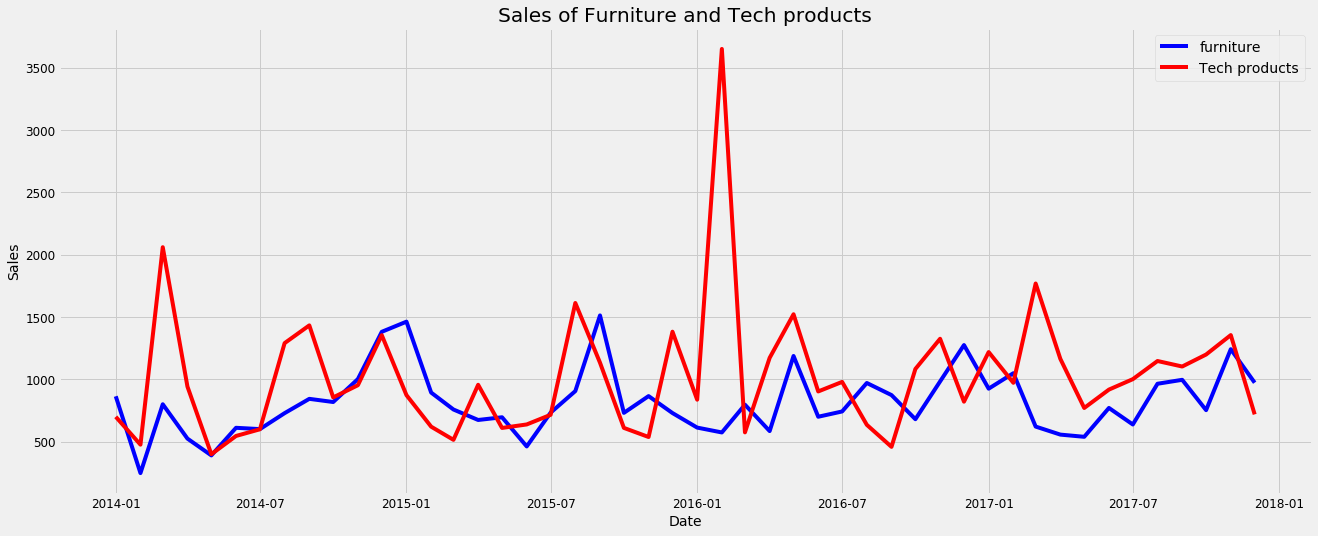

In [10]:
plt.figure(figsize=(20, 8))
plt.plot(store['OrderDate'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['OrderDate'], store['Tech_sales'], 'r-', label = 'Tech products')
plt.xlabel('Date'); plt.ylabel('Sales'); 
plt.title('Sales of Furniture and Tech products')
plt.legend();

## Observation : 
        There is huge spike in sale of Tech products. For forecasring this should be treated as outlier.
        It needs to be verified with business team. Any bigday sales or what is the reason for this surge in sale of Tech  
        products
        
        Seasonal patten looks similar for furniture and tech product sales & We will see how the sales correlates with each other

In [1]:
from fbprophet import Prophet

In [12]:
furniture = furniture.rename(columns={'OrderDate': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)


Tech_prds = Tech_prds.rename(columns={'OrderDate': 'ds', 'Sales': 'y'})
Tech_prds_model = Prophet(interval_width=0.95)
Tech_prds_model.fit(Tech_prds)


furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

Tech_prds_forecast = Tech_prds_model.make_future_dataframe(periods=36, freq='MS')
Tech_prds_forecast = Tech_prds_model.predict(Tech_prds_forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Furniture Sales forecast with Prophet

<Figure size 1296x432 with 0 Axes>

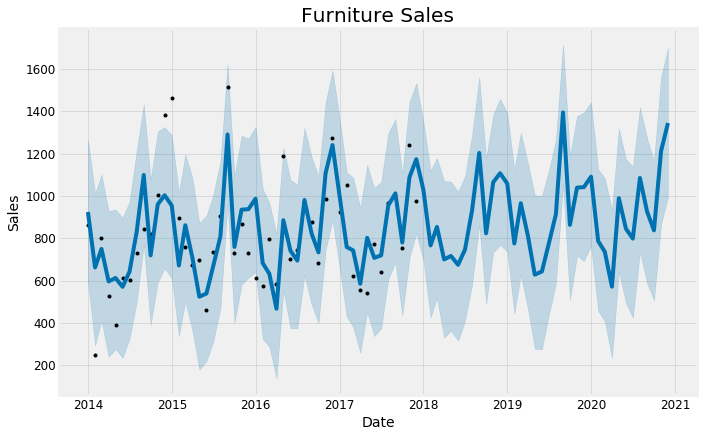

In [13]:
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

## Tech products Sales forecast with Prophet

<Figure size 1296x432 with 0 Axes>

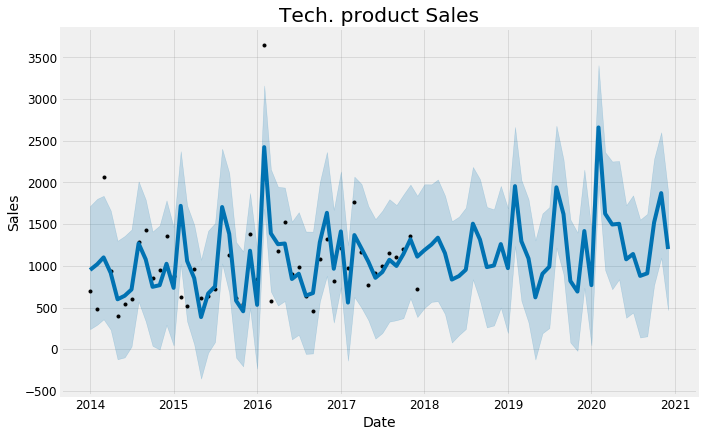

In [14]:
plt.figure(figsize=(18, 6))
Tech_prds_model.plot(Tech_prds_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Tech. product Sales');

## Comparing the forecast of two products 

In [18]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
Tech_prds_names = ['Tech_prds_%s' % column for column in Tech_prds_forecast.columns]

merge_furniture_forecast = furniture_forecast.copy()
merge_Tech_prds_forecast = Tech_prds_forecast.copy()

merge_furniture_forecast.columns = furniture_names
merge_Tech_prds_forecast.columns = Tech_prds_names

In [20]:
forecast = pd.merge(merge_furniture_forecast, merge_Tech_prds_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'Tech_prds_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('Tech_prds_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,Tech_prds_additive_terms,Tech_prds_additive_terms_lower,Tech_prds_additive_terms_upper,Tech_prds_yearly,Tech_prds_yearly_lower,Tech_prds_yearly_upper,Tech_prds_multiplicative_terms,Tech_prds_multiplicative_terms_lower,Tech_prds_multiplicative_terms_upper,Tech_prds_yhat
0,2014-01-01,774.335686,591.796026,1264.963229,774.335686,774.335686,149.524142,149.524142,149.524142,149.524142,...,-246.698965,-246.698965,-246.698965,-246.698965,-246.698965,-246.698965,0.0,0.0,0.0,950.638698
1,2014-02-01,776.546227,293.090072,1012.377395,776.546227,776.546227,-114.939818,-114.939818,-114.939818,-114.939818,...,-183.626967,-183.626967,-183.626967,-183.626967,-183.626967,-183.626967,0.0,0.0,0.0,1018.726953
2,2014-03-01,778.542844,409.763052,1100.775422,778.542844,778.542844,-29.146282,-29.146282,-29.146282,-29.146282,...,-105.862507,-105.862507,-105.862507,-105.862507,-105.862507,-105.862507,0.0,0.0,0.0,1101.022226
3,2014-04-01,780.753385,239.113350,928.420121,780.753385,780.753385,-185.155975,-185.155975,-185.155975,-185.155975,...,-296.979976,-296.979976,-296.979976,-296.979976,-296.979976,-296.979976,0.0,0.0,0.0,914.921014
4,2014-05-01,782.892618,276.292986,935.649654,782.892618,782.892618,-171.032098,-171.032098,-171.032098,-171.032098,...,-618.074540,-618.074540,-618.074540,-618.074540,-618.074540,-618.074540,0.0,0.0,0.0,598.680891


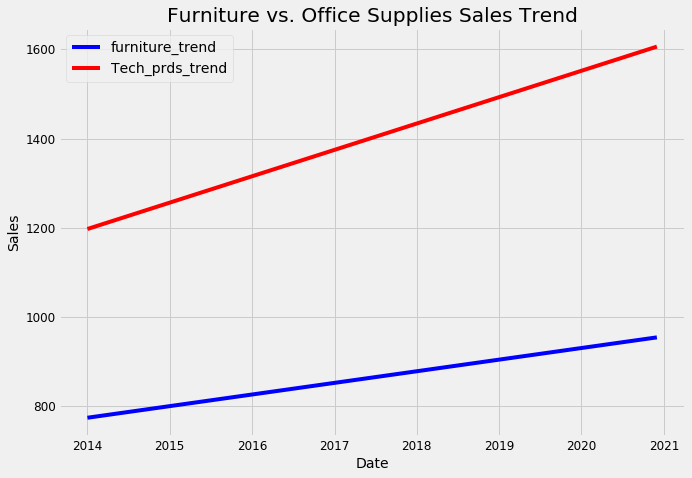

In [22]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['Tech_prds_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');

## Observations : 
Tech product trend is much more better than furniture trend, As of now there is no confluence in the sales trend. Both are seems possitive in their sales 

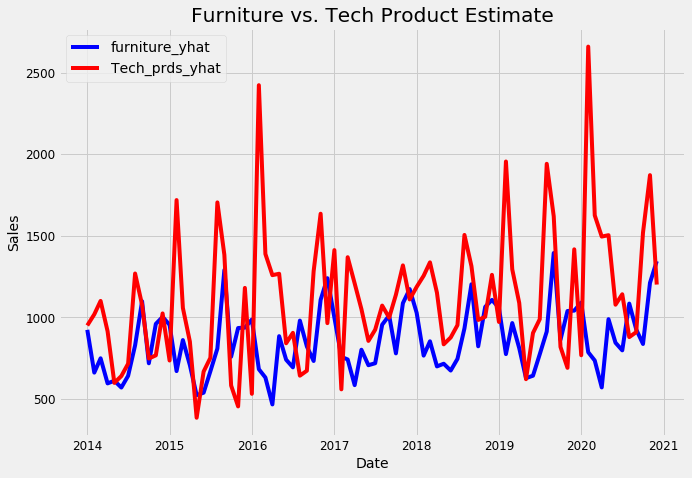

In [23]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['Tech_prds_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Tech Product Estimate');

## Analysing trends  - Furniture sales

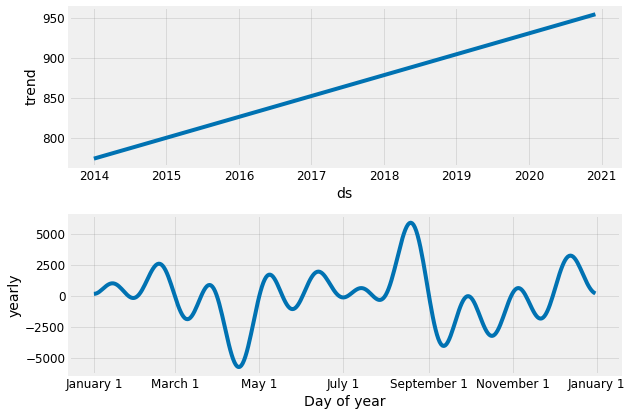

In [24]:
furniture_model.plot_components(furniture_forecast);

## Observations : 
                  Worst month for furniture sales is April 
                  Best  month for furniture sales is August

## Analysing trends  - Tech product sales

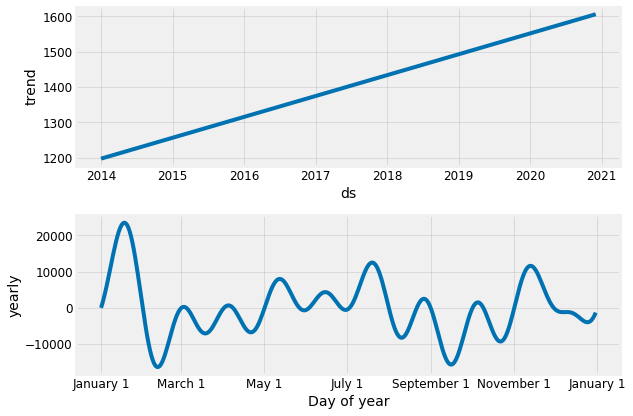

In [26]:
Tech_prds_model.plot_components(Tech_prds_forecast);

## Observations : 
                  Worst month for Tech product sales is Feb end 
                  Second Worst month for Tech product sale is september end
        
                  Best  month for Tech product sales is Mid Jan & Mid July 

## End of Analysis 